# INDEL Variant Calling Performance - by INDEL length

### Maximillian Marin
### mgmarin@g.harvard.edu

### Goal: To generate precision-recall curves of INDEL variant calling performance stratified by INDEL length (and by Insertion vs. Deletion)

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import statsmodels.api as sm

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Set matplotlib text export settings for Adobe Illustrator

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Parse info regarding samples of interest

In [5]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"


PMP_50CI_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_50CI_AssemblySummary_V7.tsv"

PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv" 

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       


PMP_50CI_AssemblySummary = pd.read_csv(PMP_50CI_AssemblySummary_TSV_PATH, sep = "\t")

PMP_42CI_CicularOnly_AssemblySummary = pd.read_csv(PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to lineage mapping dict

ID_To_IlluminaAvrgCov_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


In [6]:
#SampleIDs_31CI_WiCircA

## Construct dictionary with PATHs to relevant files for all samples

### Define directories to PMP-SM (PacBio assembly and analysis pipeline)

In [7]:
### Define directories to PMP-SM (PacBio assembly and analysis pipeline)

### Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"

PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"

PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"


In [8]:
!ls -1 $PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir/M0011368_9/Hap.py_VariantCalling_EvalDir/

Happy_StratificationFiles
PBMM2_Paftools_GroundTruthVCF_Evaluations_V3_minMQ_1_minDP_5_Fix_All_Breaks_AmbRegionsRemoved
PBMM2_PBonly_NoPilonPolishing_Paftools_GroundTruthVCF_Evaluations_V3_minMQ_1_minDP_5_Fix_All_Breaks_AmbRegionsRemoved


## Save the PATHs of HapPy analysis from the following masking schemes:

1) "None" <br>
2) "Hicks_Regions_Removed" <br>
3)

In [9]:
#PMP_28CI_40X_SampleIDs = SampleIDs_28CI_WiCircA

In [10]:
#",".join(PMP_28CI_40X_SampleIDs)

In [11]:
SampleID_ToPaths_Dict = {}

for SampleID in SampleIDs_36CI_SOI:

    SampleID_ToPaths_Dict[SampleID] = {}    
    
    # Defining PATHs for PacBio data output (PacmanPipe-V4)
    sample_PMP_OutputDir = PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir + "/" + SampleID
    Happy_OutDir = f"{sample_PMP_OutputDir}/Hap.py_VariantCalling_EvalDir/PBMM2_Paftools_GroundTruthVCF_Evaluations_V3_minMQ_1_minDP_5_Fix_All_Breaks_AmbRegionsRemoved"
    
    
    # No Masking ("None")
    RegionFilteringScheme = "MM2vsPilon_NoneRemoved_1to15bp"
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["SNPs"] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["INDELs"] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["ALL"] = {}
        
    Happy_Sample_Dir = f"{Happy_OutDir}/{SampleID}_Happy_VCeval_T_PB_G3PP_MM2_paftools_Vs_Q_Ill_Pilon_VCs_NoRegionsRemoved"

    Happy_G3PP_Vs_Pilon_ROC_SNPs_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.All.roc.Locations.SNP.PASS.csv.gz"
    Happy_G3PP_Vs_Pilon_ROC_INDELs_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.All.roc.Locations.INDEL.PASS.csv.gz"
    Happy_G3PP_Vs_Pilon_ROC_ALL_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.roc.all.csv.gz"
    
    
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["SNPs"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_SNPs_PASS_CSV
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["INDELs"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_INDELs_PASS_CSV
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["ALL"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_ALL_PASS_CSV

    

## What are the different INDEL subtypes?

I1_5 == Insertions of length 1-5 <br>
I6_15 == Insertions of length 6-15 <br>
I16_PLUS == Insertions of length 16 or more <br>
D1_5 == Deletions of length 1-5 <br>
D6_15 == Deletions of length 6-15 <br>
D16_PLUS == Deletions of length 16 or more <br>

In [12]:
def parse_HapPy_Benchmark_DF_and_FFILL(Sample_ROC_DF):
    """ 
    """
    
    #Sample_ROC_DF = Sample_ROC_DF.drop(Sample_ROC_DF.index[0])
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF
   

## Let's try to create a DF for a single sample for a single INDEL SUBTYPE. (ie. I1_5)

In [13]:
def parse_HapPy_Benchmark_DF_and_FFILL(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF


### UPDATED FFILL PARSER
#### This version adds a QQ==60 row to the dataframe if it doesn't exist

In [14]:
def parse_HapPy_Benchmark_DF_and_FFILL(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    
    
    if Sample_ROC_DF.shape[0] <= 1:
        print(Sample_ROC_DF.shape[0], )
        #Sample_ROC_DF["QQ"] = -10
        
        Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["Filter"] == "."]
        
        return Sample_ROC_DF

    
    #print(Sample_ROC_DF[-1:].values.shape)
    
    Sample_ROC_DF_lastRow_ToMQ60 = pd.DataFrame(Sample_ROC_DF[-1:].values,  columns=Sample_ROC_DF.columns)
    
    MQ_Thresh_OfLastRow = Sample_ROC_DF_lastRow_ToMQ60["QQ"].values[0]
    
    if MQ_Thresh_OfLastRow != 60:
        Sample_ROC_DF_lastRow_ToMQ60["QQ"] = 60

        Sample_ROC_DF = Sample_ROC_DF.append(Sample_ROC_DF_lastRow_ToMQ60)
    
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']
    
    
    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF


In [15]:
def parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF_OG = Sample_ROC_DF.copy()
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    if Sample_ROC_DF.shape[0] <= 1:
        #print(Sample_ROC_DF.shape[0] )
        Sample_ROC_DF["QQ"] = -10
        return Sample_ROC_DF

    


    Sample_ROC_DF_lastRow_ToMQ60 = pd.DataFrame(Sample_ROC_DF.iloc[[-1]].values,  columns=Sample_ROC_DF.columns)
    MQ_Thresh_OfLastRow = Sample_ROC_DF_lastRow_ToMQ60["QQ"].values[0]

    if MQ_Thresh_OfLastRow != 60:
        print("Max QQ in table", Sample_ROC_DF.QQ.max() )
        Sample_ROC_DF_lastRow_ToMQ60["QQ"] = 60
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Recall"] = 0 # np.nan #0 # Set Recall to ZERO b/c there are still FN, but not a single one was called
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Precision"] = 1 # np.nan #0  # Set Precision to NAN b/c there were no Positive calls made at all
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.F1_Score"] = 0 # np.nan #0   # Set F1 score to ZERO b/c Recall is ZERO
    

        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TPs"] = 0
        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TOTAL] + Sample_ROC_DF_lastRow_ToMQ60["TRUTH.TP"]


        Sample_ROC_DF_lastRow_ToMQ60.index = [60]

        Sample_ROC_DF = Sample_ROC_DF.append(Sample_ROC_DF_lastRow_ToMQ60)


    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  

    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()

    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)

    return Sample_ROC_DF


In [16]:

listOf_FilteringSchemes = ["MM2vsPilon_NoneRemoved_1to15bp"] 


#listOf_VariantTypes = ["SNPs", "INDELs"]
listOf_VariantTypes = ["ALL"]

#listOf_INDEL_Subtypes = ['D1_5', 'I1_5', 'D16_PLUS', 'I6_15', 'D6_15', 'I16_PLUS']
listOf_INDEL_Subtypes = ['D1_5', 'I1_5', 'I6_15', 'D6_15', ]

                         
listOf_HapPy_DFs = []

for RegionFilteringScheme in tqdm(listOf_FilteringSchemes):
    for SampleID in (SampleIDs_36CI_SOI):
        for variantType in listOf_VariantTypes:
                   
            i_HapPy_ROC_PASS_CSV_PATH = SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme][variantType]["Happy_ROC_PASS_CSV"]                      

            i_HapPy_ALL_DF = pd.read_csv(i_HapPy_ROC_PASS_CSV_PATH)
            i_HapPy_ALL_PASS_DF = i_HapPy_ALL_DF[ i_HapPy_ALL_DF["Filter"] == "PASS"]
            i_HapPy_ALL_PASS_INDEL_DF = i_HapPy_ALL_PASS_DF[ i_HapPy_ALL_PASS_DF["Type"] == "INDEL"]
                        
                         
            for INDEL_Subtype in listOf_INDEL_Subtypes:             
 
                i_ALL_PASS_INDEL_DF_Subtype = i_HapPy_ALL_PASS_INDEL_DF[ (i_HapPy_ALL_PASS_INDEL_DF["Subtype"] == INDEL_Subtype) & ( i_HapPy_ALL_PASS_INDEL_DF["Subset"] == "*" )]

                i_ALL_PASS_INDEL_DF_Subtype_FF = parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(i_ALL_PASS_INDEL_DF_Subtype)

                         
                columnsToKeep_HappyTable = ['Type', 'Subtype', 'Subset', 'Filter', 'Genotype', 'QQ.Field',
                                             'QQ', 'METRIC.Recall', 'METRIC.Precision', 'METRIC.Frac_NA',
                                             'METRIC.F1_Score', 'TRUTH.TP', 'TRUTH.FN', 'QUERY.TP',
                                             'QUERY.FP', 'QUERY.UNK']
                
                
                #print(SampleID, INDEL_Subtype, i_ALL_PASS_INDEL_DF_Subtype_FF.shape)
                
                #print(SampleID)
                
                i_VC_PR_Curve_DF = i_ALL_PASS_INDEL_DF_Subtype_FF[columnsToKeep_HappyTable]

                if i_VC_PR_Curve_DF.shape[0] < 3: 
                    print(SampleID)
                    #continue
                    
                #print(SampleID, INDEL_Subtype, i_ALL_PASS_INDEL_DF_Subtype_FF.shape)
  
                i_VC_PR_Curve_DF.loc[:,'SampleID'] = SampleID
                i_VC_PR_Curve_DF.loc[:,'RegionFilteringScheme'] = RegionFilteringScheme
                i_VC_PR_Curve_DF.loc[:,'variantType'] = variantType

                listOf_HapPy_DFs.append(i_VC_PR_Curve_DF)

HapPy_PR_DF = pd.concat(listOf_HapPy_DFs)

HapPy_PR_DF["QQ"] = HapPy_PR_DF["QQ"].astype(int) #Experimental

  0%|          | 0/1 [00:00<?, ?it/s]/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0
Max QQ in table 59.0


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

Max QQ in table 59.0


In [17]:
i_ALL_PASS_INDEL_DF_Subtype.sort_values("QQ")

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,FP.gt,FP.al,Subset.Size,Subset.IS_CONF.Size,Subset.Level,TRUTH.TOTAL,TRUTH.TOTAL.ti,TRUTH.TOTAL.tv,TRUTH.TOTAL.het,TRUTH.TOTAL.homalt,TRUTH.TOTAL.TiTv_ratio,TRUTH.TOTAL.het_hom_ratio,TRUTH.TP,TRUTH.TP.ti,TRUTH.TP.tv,TRUTH.TP.het,TRUTH.TP.homalt,TRUTH.TP.TiTv_ratio,TRUTH.TP.het_hom_ratio,TRUTH.FN,TRUTH.FN.ti,TRUTH.FN.tv,TRUTH.FN.het,TRUTH.FN.homalt,TRUTH.FN.TiTv_ratio,TRUTH.FN.het_hom_ratio,QUERY.TOTAL,QUERY.TOTAL.ti,QUERY.TOTAL.tv,QUERY.TOTAL.het,QUERY.TOTAL.homalt,QUERY.TOTAL.TiTv_ratio,QUERY.TOTAL.het_hom_ratio,QUERY.TP,QUERY.TP.ti,QUERY.TP.tv,QUERY.TP.het,QUERY.TP.homalt,QUERY.TP.TiTv_ratio,QUERY.TP.het_hom_ratio,QUERY.FP,QUERY.FP.ti,QUERY.FP.tv,QUERY.FP.het,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
64,INDEL,D6_15,*,PASS,*,INFO.MQ,*,0.777778,0.875,0.0,0.823529,0,1,4411532.0,4399616.0,0.0,9,.,.,0.000000,9.000000,NaN,0.0,7,.,.,0.000000,7.000000,NaN,0.0,2,.,.,0.000000,2.000000,NaN,0.0,8,.,.,0.000000,8.000000,NaN,0.0,7,.,.,0.000000,7.000000,NaN,0.0,1,.,.,0.000000,1.000000,NaN,0.0,0,.,.,0.000000,0.000000,NaN,NaN
65,INDEL,D6_15,*,PASS,*,INFO.MQ,0.000000,0.777778,1.000,0.0,0.875000,0,0,4411532.0,4399616.0,0.0,9,.,.,.,.,NaN,NaN,7,.,.,.,.,NaN,NaN,2,.,.,.,.,NaN,NaN,7,.,.,.,.,NaN,NaN,7,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN
66,INDEL,D6_15,*,PASS,*,INFO.MQ,59.000000,0.777778,1.000,0.0,0.875000,0,0,4411532.0,4399616.0,0.0,9,.,.,.,.,NaN,NaN,7,.,.,.,.,NaN,NaN,2,.,.,.,.,NaN,NaN,6,.,.,.,.,NaN,NaN,6,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN
67,INDEL,D6_15,*,PASS,*,INFO.MQ,60.000000,0.666667,1.000,0.0,0.800000,0,0,4411532.0,4399616.0,0.0,9,.,.,.,.,NaN,NaN,6,.,.,.,.,NaN,NaN,3,.,.,.,.,NaN,NaN,5,.,.,.,.,NaN,NaN,5,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN,0,.,.,.,.,NaN,NaN


In [18]:
HapPy_PR_DF.head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType
0,INDEL,D1_5,*,PASS,*,INFO.MQ,0,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
1,INDEL,D1_5,*,PASS,*,INFO.MQ,1,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
2,INDEL,D1_5,*,PASS,*,INFO.MQ,2,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL


In [19]:
#HapPy_PR_DF[ HapPy_PR_DF["Subtype"] == "I6_15"]["QQ"].value_counts()

In [20]:
HapPy_PR_DF["Subtype"].value_counts()

D1_5     2196
I6_15    2196
D6_15    2196
I1_5     2157
Name: Subtype, dtype: int64

In [21]:
HapPy_PR_DF["Subtype"].value_counts()

D1_5     2196
I6_15    2196
D6_15    2196
I1_5     2157
Name: Subtype, dtype: int64

In [22]:
HapPy_PR_DF["Subtype"].value_counts()

D1_5     2196
I6_15    2196
D6_15    2196
I1_5     2157
Name: Subtype, dtype: int64

In [23]:
HapPy_PR_DF_N0153 = HapPy_PR_DF[ HapPy_PR_DF["SampleID"] == "N0153"]

In [24]:
HapPy_PR_DF_N0153.shape

(244, 19)

In [25]:
HapPy_PR_DF_N0153["Subtype"].value_counts()

D1_5     61
D6_15    61
I1_5     61
I6_15    61
Name: Subtype, dtype: int64

In [26]:
HapPy_PR_DF_N0153["Subtype"].value_counts()

D1_5     61
D6_15    61
I1_5     61
I6_15    61
Name: Subtype, dtype: int64

In [27]:
HapPy_PR_DF[ HapPy_PR_DF["SampleID"] == "RW-TB008"]["Subtype"].value_counts()

D1_5     61
D6_15    61
I1_5     61
I6_15    61
Name: Subtype, dtype: int64

In [28]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 50) & (HapPy_PR_DF["Subtype"] == "I6_15")  ].shape

(36, 19)

In [29]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 50) & (HapPy_PR_DF["Subtype"] == "I6_15")  ].head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType
50,INDEL,I6_15,*,PASS,*,INFO.MQ,50,0.461538,1.000,0.0,0.631579,6.0,7.0,6.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
50,INDEL,I6_15,*,PASS,*,INFO.MQ,50,0.470588,1.000,0.0,0.640000,8.0,9.0,8.0,0.0,0.0,M0014888_3,MM2vsPilon_NoneRemoved_1to15bp,ALL
50,INDEL,I6_15,*,PASS,*,INFO.MQ,50,0.428571,0.875,0.0,0.575342,6.0,8.0,7.0,1.0,0.0,M0016395_7,MM2vsPilon_NoneRemoved_1to15bp,ALL


In [30]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 59) & (HapPy_PR_DF["Subtype"] == "I6_15")  ].shape

(36, 19)

In [31]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 60) & (HapPy_PR_DF["Subtype"] == "I6_15")  ].shape

(36, 19)

In [32]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 60) & (HapPy_PR_DF["Subtype"] == "I6_15")  ].head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType
60,INDEL,I6_15,*,PASS,*,INFO.MQ,60,0.0,1.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
60,INDEL,I6_15,*,PASS,*,INFO.MQ,60,0.0,1.0,0.0,0.0,0.0,17.0,1.0,0.0,0.0,M0014888_3,MM2vsPilon_NoneRemoved_1to15bp,ALL
60,INDEL,I6_15,*,PASS,*,INFO.MQ,60,0.0,1.0,0.0,0.0,2.0,12.0,1.0,0.0,0.0,M0016395_7,MM2vsPilon_NoneRemoved_1to15bp,ALL


# Average performance across filtering schemes, thresholds, subtypes

In [33]:
HapPy_Mean_PR_DF = HapPy_PR_DF.groupby(["QQ", "RegionFilteringScheme", "Type", "Subtype", "Subset"]).mean().reset_index()   


HapPy_SEM_PR_DF = HapPy_PR_DF.groupby(["QQ", "RegionFilteringScheme", "Type", "Subtype", "Subset"]).sem().reset_index()


ColumnsToMergeOn = ["QQ", "RegionFilteringScheme", "Type", "Subtype", "Subset"]

HapPy_Mean_PR_DF = HapPy_Mean_PR_DF.merge(HapPy_SEM_PR_DF,
                                                     left_on = ColumnsToMergeOn,
                                                     right_on = ColumnsToMergeOn,
                                                     suffixes=('_MEAN', '_SEM') ).reset_index(drop=True)



In [34]:
HapPy_Mean_PR_DF["Subtype"].value_counts()

D1_5     61
D6_15    61
I1_5     61
I6_15    61
Name: Subtype, dtype: int64

In [35]:
HapPy_Mean_PR_DF.shape

(244, 23)

In [36]:
#HapPy_Mean_PR_DF.head()

In [37]:
HapPy_Mean_PR_DF.head()

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778
1,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.724138,0.906572,0.006636,0.794825,9.944444,4.194444,9.777778,1.055556,0.083333,0.025803,0.013125,0.003826,0.018120,0.564765,0.495727,0.567802,0.148775,0.046718
2,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.905197,0.989297,0.009584,0.944499,46.942857,4.942857,47.942857,0.514286,0.485714,0.009087,0.002036,0.002740,0.005017,3.170490,0.596830,3.165715,0.095014,0.144195
3,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.636221,0.950318,0.000000,0.755860,11.250000,6.527778,11.250000,0.638889,0.000000,0.021552,0.009142,0.000000,0.018180,0.794200,0.568325,0.793200,0.120533,0.000000
4,1,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778


# Output SNS and INDEL variant calling results for supplemental tables

## A) Output Averaged Precision-Recall curves (Mean of 36 isolates)

In [38]:
HapPy_Mean_PR_DF_INDELs = HapPy_Mean_PR_DF.copy()

In [39]:
HapPy_Mean_PR_DF_INDELs.head()

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778
1,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.724138,0.906572,0.006636,0.794825,9.944444,4.194444,9.777778,1.055556,0.083333,0.025803,0.013125,0.003826,0.018120,0.564765,0.495727,0.567802,0.148775,0.046718
2,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.905197,0.989297,0.009584,0.944499,46.942857,4.942857,47.942857,0.514286,0.485714,0.009087,0.002036,0.002740,0.005017,3.170490,0.596830,3.165715,0.095014,0.144195
3,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.636221,0.950318,0.000000,0.755860,11.250000,6.527778,11.250000,0.638889,0.000000,0.021552,0.009142,0.000000,0.018180,0.794200,0.568325,0.793200,0.120533,0.000000
4,1,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778


In [40]:
HapPy_Mean_PR_DF_INDELs.columns

Index(['QQ', 'RegionFilteringScheme', 'Type', 'Subtype', 'Subset', 'METRIC.Recall_MEAN', 'METRIC.Precision_MEAN', 'METRIC.Frac_NA_MEAN', 'METRIC.F1_Score_MEAN', 'TRUTH.TP_MEAN', 'TRUTH.FN_MEAN', 'QUERY.TP_MEAN', 'QUERY.FP_MEAN', 'QUERY.UNK_MEAN', 'METRIC.Recall_SEM', 'METRIC.Precision_SEM', 'METRIC.Frac_NA_SEM', 'METRIC.F1_Score_SEM', 'TRUTH.TP_SEM', 'TRUTH.FN_SEM', 'QUERY.TP_SEM', 'QUERY.FP_SEM', 'QUERY.UNK_SEM'], dtype='object')

In [41]:
Happy_ColNeededForExport = ['QQ', 'RegionFilteringScheme', 'Subtype', 'Type', 'METRIC.Recall_MEAN', 'METRIC.Precision_MEAN', 'METRIC.F1_Score_MEAN',
                            'METRIC.Recall_SEM', 'METRIC.Precision_SEM', 'METRIC.F1_Score_SEM' ]

HapPy_PR_DF_INDELs_Averaged_TrimCol = HapPy_Mean_PR_DF_INDELs[Happy_ColNeededForExport]
HapPy_PR_DF_INDELs_Averaged_TrimCol.head(3)

,QQ,RegionFilteringScheme,Subtype,Type,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.F1_Score_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.F1_Score_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,D1_5,INDEL,0.842452,0.966583,0.894353,0.019713,0.005692,0.012541
1,0,MM2vsPilon_NoneRemoved_1to15bp,D6_15,INDEL,0.724138,0.906572,0.794825,0.025803,0.013125,0.018120
2,0,MM2vsPilon_NoneRemoved_1to15bp,I1_5,INDEL,0.905197,0.989297,0.944499,0.009087,0.002036,0.005017


In [42]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

Happy_VC_Eval_ResultsDir = f"{PB_Vs_Illumina_DataAnalysis_Dir}/Happy_VC_Eval_ResultsDir_36CI"

!mkdir $Happy_VC_Eval_ResultsDir

PR_Curve_INDELs_VC_Results_TSV_PATH = f"{Happy_VC_Eval_ResultsDir}/Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.AveragedResults.tsv"

HapPy_PR_DF_INDELs_Averaged_TrimCol.to_csv(PR_Curve_INDELs_VC_Results_TSV_PATH, sep = "\t", index=False)

mkdir: cannot create directory ‘../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/Happy_VC_Eval_ResultsDir_36CI’: File exists


In [43]:
HapPy_PR_DF_INDELs_Averaged_TrimCol.head()

,QQ,RegionFilteringScheme,Subtype,Type,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.F1_Score_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.F1_Score_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,D1_5,INDEL,0.842452,0.966583,0.894353,0.019713,0.005692,0.012541
1,0,MM2vsPilon_NoneRemoved_1to15bp,D6_15,INDEL,0.724138,0.906572,0.794825,0.025803,0.013125,0.018120
2,0,MM2vsPilon_NoneRemoved_1to15bp,I1_5,INDEL,0.905197,0.989297,0.944499,0.009087,0.002036,0.005017
3,0,MM2vsPilon_NoneRemoved_1to15bp,I6_15,INDEL,0.636221,0.950318,0.755860,0.021552,0.009142,0.018180
4,1,MM2vsPilon_NoneRemoved_1to15bp,D1_5,INDEL,0.842452,0.966583,0.894353,0.019713,0.005692,0.012541


In [44]:
!head -n 4 $PR_Curve_INDELs_VC_Results_TSV_PATH

QQ	RegionFilteringScheme	Subtype	Type	METRIC.Recall_MEAN	METRIC.Precision_MEAN	METRIC.F1_Score_MEAN	METRIC.Recall_SEM	METRIC.Precision_SEM	METRIC.F1_Score_SEM
0	MM2vsPilon_NoneRemoved_1to15bp	D1_5	INDEL	0.8424520277777777	0.9665829444444446	0.8943530833333335	0.019713219843042813	0.005692142105910573	0.012540896116077433
0	MM2vsPilon_NoneRemoved_1to15bp	D6_15	INDEL	0.7241383888888888	0.9065723888888889	0.7948247500000001	0.02580333343939437	0.013124678146032716	0.018120330926687255
0	MM2vsPilon_NoneRemoved_1to15bp	I1_5	INDEL	0.9051974285714287	0.9892966285714286	0.9444993999999997	0.009086612833560968	0.0020357662402687607	0.005016921898581895


## B) Output individual Precision-Recall curves (Each PR curve for 36 isolates)

In [45]:
HapPy_PR_DF_IndivCurves_INDELs_ByLength = HapPy_PR_DF.copy()

In [46]:
HapPy_PR_DF_IndivCurves_INDELs_ByLength.head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType
0,INDEL,D1_5,*,PASS,*,INFO.MQ,0,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
1,INDEL,D1_5,*,PASS,*,INFO.MQ,1,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL
2,INDEL,D1_5,*,PASS,*,INFO.MQ,2,0.827586,1.0,0.0,0.90566,24.0,5.0,25.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_1to15bp,ALL


In [47]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

Happy_VC_Eval_ResultsDir = f"{PB_Vs_Illumina_DataAnalysis_Dir}/Happy_VC_Eval_ResultsDir_36CI"

!mkdir $Happy_VC_Eval_ResultsDir

PR_Curve_Individual_SNS_VC_Results_TSV_PATH = f"{Happy_VC_Eval_ResultsDir}/Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.IndividualResults.tsv"        

HapPy_PR_DF_IndivCurves_INDELs_ByLength.to_csv(PR_Curve_Individual_SNS_VC_Results_TSV_PATH, sep = "\t", index=False)


mkdir: cannot create directory ‘../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/Happy_VC_Eval_ResultsDir_36CI’: File exists


In [48]:
!ls -lah $Happy_VC_Eval_ResultsDir

total 872K
drwxrwsr-x  2 mm774 farhat  658 Mar 29 00:47 .
drwxrwsr-x 12 mm774 farhat  574 Mar 29 19:36 ..
-rw-rw-r--  1 mm774 farhat  29K Apr  3 15:08 Benchmarking.HapPy.INDELs.36CI.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 868K Apr  3 15:08 Benchmarking.HapPy.INDELs.36CI.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  40K Apr  3 16:03 Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 1.1M Apr  3 16:03 Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  29K Apr  3 15:08 Benchmarking.HapPy.SNSs.36CI.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 885K Apr  3 15:08 Benchmarking.HapPy.SNSs.36CI.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  34K Apr  3 15:43 Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 1.4M Apr  3 15:43 Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.IndividualResults.tsv


In [49]:
HapPy_Mean_PR_DF[ (HapPy_Mean_PR_DF["QQ"] == 0 ) & (HapPy_Mean_PR_DF["RegionFilteringScheme"] == "MM2vsPilon_NoneRemoved_1to15bp" )]

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778
1,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.724138,0.906572,0.006636,0.794825,9.944444,4.194444,9.777778,1.055556,0.083333,0.025803,0.013125,0.003826,0.018120,0.564765,0.495727,0.567802,0.148775,0.046718
2,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.905197,0.989297,0.009584,0.944499,46.942857,4.942857,47.942857,0.514286,0.485714,0.009087,0.002036,0.002740,0.005017,3.170490,0.596830,3.165715,0.095014,0.144195
3,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.636221,0.950318,0.000000,0.755860,11.250000,6.527778,11.250000,0.638889,0.000000,0.021552,0.009142,0.000000,0.018180,0.794200,0.568325,0.793200,0.120533,0.000000


In [50]:
HapPy_Mean_PR_DF[ (HapPy_Mean_PR_DF["QQ"] == 60 ) & (HapPy_Mean_PR_DF["RegionFilteringScheme"] == "MM2vsPilon_NoneRemoved_1to15bp" )]

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
240,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.709495,0.997975,0.000000,0.820214,35.888889,16.944444,36.527778,0.055556,0.000000,0.024511,0.001439,0.000000,0.018859,1.991162,2.195936,2.019149,0.038718,0.000000
241,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.414292,1.000000,0.000000,0.551419,5.388889,8.750000,5.416667,0.000000,0.000000,0.036699,0.000000,0.000000,0.038303,0.420275,0.901828,0.426084,0.000000,0.000000
242,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.733661,0.996432,0.001029,0.836131,36.055556,15.277778,36.694444,0.111111,0.027778,0.024062,0.001717,0.001029,0.018402,2.168294,2.341012,2.181749,0.053121,0.027778
243,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.013668,0.861111,0.000000,0.013492,2.666667,15.111111,2.444444,0.000000,0.000000,0.005843,0.058456,0.000000,0.009557,0.436436,1.122482,0.422473,0.000000,0.000000


In [51]:
HapPy_Mean_PR_DF[ (HapPy_Mean_PR_DF["QQ"] == 40 ) & (HapPy_Mean_PR_DF["RegionFilteringScheme"] == "MM2vsPilon_NoneRemoved_1to15bp" )]

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
160,40,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.830451,0.994280,0.000427,0.900079,43.972222,8.861111,44.972222,0.277778,0.027778,0.019082,0.001996,0.000427,0.012735,2.962058,1.237094,2.959109,0.085552,0.027778
161,40,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.717928,0.926453,0.002315,0.797221,9.833333,4.305556,9.666667,0.805556,0.027778,0.026362,0.013047,0.002315,0.018024,0.549892,0.509932,0.549170,0.142648,0.027778
162,40,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.896387,0.989765,0.009113,0.939785,45.944444,5.388889,47.000000,0.472222,0.444444,0.009585,0.002067,0.002724,0.005362,3.075749,0.631549,3.089152,0.093317,0.140546
163,40,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.614893,0.966084,0.000000,0.743416,10.972222,6.805556,10.944444,0.388889,0.000000,0.022690,0.008755,0.000000,0.019336,0.803253,0.565993,0.803706,0.091528,0.000000


In [51]:
HapPy_Mean_PR_DF.sort_values( "METRIC.Precision_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
231,57,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.523753,1.0,0.0,0.673177,9.277778,8.5,8.944444,0.0,0.0,0.025986,0.0,0.0,0.024328,0.740668,0.68949,0.734571,0.0,0.0


In [52]:
HapPy_Mean_PR_DF.sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
98,24,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.905197,0.989658,0.009227,0.944664,46.942857,4.942857,47.942857,0.485714,0.457143,0.009087,0.002058,0.002752,0.00502,3.17049,0.59683,3.165715,0.095014,0.144029


In [53]:
HapPy_Mean_PR_DF["Subtype"].value_counts()

I1_5     61
D6_15    61
I6_15    61
D1_5     61
Name: Subtype, dtype: int64

In [54]:
HapPy_Mean_PR_DF[ (HapPy_Mean_PR_DF["QQ"] == 60)]

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
240,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.709495,0.997975,0.000000,0.820214,35.888889,16.944444,36.527778,0.055556,0.000000,0.024511,0.001439,0.000000,0.018859,1.991162,2.195936,2.019149,0.038718,0.000000
241,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.414292,1.000000,0.000000,0.551419,5.388889,8.750000,5.416667,0.000000,0.000000,0.036699,0.000000,0.000000,0.038303,0.420275,0.901828,0.426084,0.000000,0.000000
242,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.733661,0.996432,0.001029,0.836131,36.055556,15.277778,36.694444,0.111111,0.027778,0.024062,0.001717,0.001029,0.018402,2.168294,2.341012,2.181749,0.053121,0.027778
243,60,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.013668,0.861111,0.000000,0.013492,2.666667,15.111111,2.444444,0.000000,0.000000,0.005843,0.058456,0.000000,0.009557,0.436436,1.122482,0.422473,0.000000,0.000000


### Plotting Precision-Recall curves for INDEL calling - stratified by length

In [55]:
HapPy_Mean_PR_DF_NoneRemoved = HapPy_Mean_PR_DF[ HapPy_Mean_PR_DF["RegionFilteringScheme"] == "MM2vsPilon_NoneRemoved_1to15bp"]
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55 = HapPy_Mean_PR_DF_NoneRemoved[ HapPy_Mean_PR_DF_NoneRemoved["QQ"].isin(  [0,]  +   list(np.arange(1, 59, 1)) )]               

HapPy_Mean_PR_DF_NoneRemoved_QQ_0to60 = HapPy_Mean_PR_DF_NoneRemoved[ HapPy_Mean_PR_DF_NoneRemoved["QQ"].isin(  [0,]  +   list(np.arange(5, 65, 5)) )]               


mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


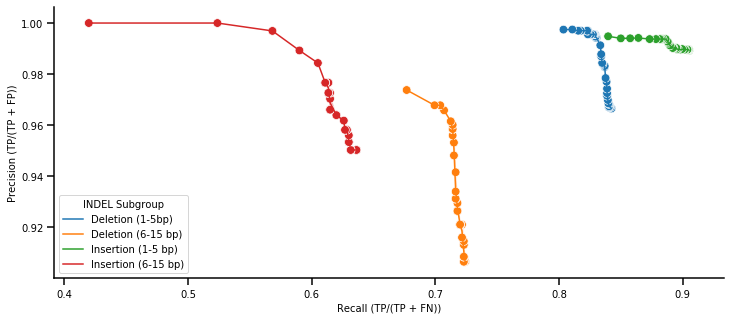

In [56]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subtype", #style = "variantType",
                data = input_DF, ax=axes, legend=None, s=75)

#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.5, 1.04)
#axes.set_xlim(0.72,1.04)

#axes.tick_params(labelsize= 25)
axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)


plt.legend(title='INDEL Subgroup', loc='lower left', labels=['Deletion (1-5bp)', "Deletion (6-15 bp)", 'Insertion (1-5 bp)', 'Insertion (6-15 bp)',])


!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/SupFig5_VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to55_V1.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/SupFig5_VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to55_V1.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [57]:
listOf_INDEL_Subtypes = ["I1_5",
                           "I6_15", 
                           "D1_5",
                           "D6_15"]


dictOf_INDEL_SubtypeToColor = {"I1_5" : "green",
                              "I6_15" : "red", 
                              "D1_5" : "blue",
                              "D6_15" : "orange" }



mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


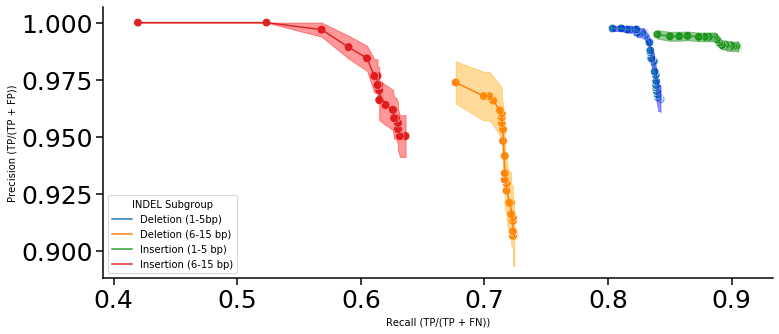

In [58]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subtype", #style = "variantType",
                data = input_DF, ax=axes, legend=None, s=75)


for i_subtype in listOf_INDEL_Subtypes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subtype"] == i_subtype ]
    
    i_color = dictOf_INDEL_SubtypeToColor[i_subtype]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)


#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.5, 1.04)
#axes.set_xlim(0.72,1.04)

axes.tick_params(labelsize= 25)
axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)


plt.legend(title='INDEL Subgroup', loc='lower left', labels=['Deletion (1-5bp)', "Deletion (6-15 bp)", 'Insertion (1-5 bp)', 'Insertion (6-15 bp)',])

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/SupFig5_VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to55_V1_PrecisionSEM_Shaded.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/SupFig5_VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to55_V1_PrecisionSEM_Shaded.pdf"       

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


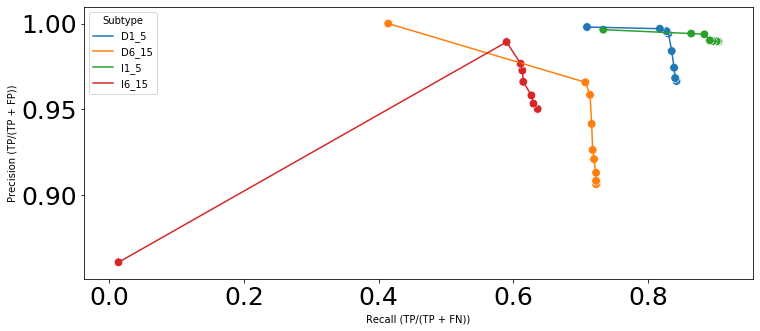

In [59]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved_QQ_0to60

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subtype", #style = "variantType",
                data = input_DF, ax=axes, legend=None, s=75)


#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.5, 1.04)
#axes.set_xlim(0.72,1.04)

axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/


Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_28CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to60_V1.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_28CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to60_V1.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [60]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55.head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
0,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.842452,0.966583,0.000403,0.894353,44.666667,8.166667,45.666667,1.583333,0.027778,0.019713,0.005692,0.000403,0.012541,3.028961,1.236033,3.027126,0.230166,0.027778


In [61]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55["Subtype"].value_counts()

I1_5     59
D6_15    59
I6_15    59
D1_5     59
Name: Subtype, dtype: int64

In [62]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55["Subtype"].value_counts()

I1_5     59
D6_15    59
I6_15    59
D1_5     59
Name: Subtype, dtype: int64

In [63]:
HapPy_Mean_PR_DF_NoneRemoved[  (HapPy_Mean_PR_DF_NoneRemoved["Subtype"] == "I1_5")].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)  

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
98,24,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I1_5,*,0.905197,0.989658,0.009227,0.944664,46.942857,4.942857,47.942857,0.485714,0.457143,0.009087,0.002058,0.002752,0.00502,3.17049,0.59683,3.165715,0.095014,0.144029


In [64]:
HapPy_Mean_PR_DF_NoneRemoved[  (HapPy_Mean_PR_DF_NoneRemoved["Subtype"] == "D1_5")].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
156,39,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D1_5,*,0.833477,0.991307,0.000427,0.900497,44.111111,8.722222,45.055556,0.388889,0.027778,0.019255,0.00228,0.000427,0.012757,2.962672,1.23867,2.967,0.091528,0.027778


In [65]:
HapPy_Mean_PR_DF_NoneRemoved[  (HapPy_Mean_PR_DF_NoneRemoved["Subtype"] == "I6_15")].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
3,0,MM2vsPilon_NoneRemoved_1to15bp,INDEL,I6_15,*,0.636221,0.950318,0.0,0.75586,11.25,6.527778,11.25,0.638889,0.0,0.021552,0.009142,0.0,0.01818,0.7942,0.568325,0.7932,0.120533,0.0


In [66]:
HapPy_Mean_PR_DF_NoneRemoved[  (HapPy_Mean_PR_DF_NoneRemoved["Subtype"] == "D6_15")].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,Type,Subtype,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM
213,53,MM2vsPilon_NoneRemoved_1to15bp,INDEL,D6_15,*,0.714048,0.960158,0.002315,0.805597,9.75,4.388889,9.638889,0.416667,0.027778,0.026953,0.011265,0.002315,0.018091,0.53656,0.531959,0.540653,0.115298,0.027778


In [67]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
listOf_FilteringSchemes

In [ ]:
i_subtype

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subtype", #style = "variantType",
                data = input_DF, ax=axes, legend=None, s=75)


for i_subtype in listOf_INDEL_Subtypes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subtype"] == i_subtype ]
    
    i_color = dictOf_INDEL_SubtypeToColor[i_subtype]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)






#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.5, 1.04)
#axes.set_xlim(0.72,1.04)

axes.tick_params(labelsize= 25)


plt.legend(title='INDEL Subgroup', loc='lower left', labels=['Deletion (1-5bp)', "Deletion (6-15 bp)", 'Insertion (1-5 bp)', 'Insertion (6-15 bp)',])


!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to60_V1_PrecisionSEM_Shaded.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_MQ_0to60_V1_PrecisionSEM_Shaded.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
STOP

### Plotting F1-score distributions for INDEL calling - stratified by length

In [ ]:
sns.boxplot(y="Subtype",
            x="METRIC.F1_Score",
            data = HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55)

#!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_28CI_INDELs_ByLength_F1score_Distributions_INDELsubtypeANDlength_MQ_0to60_V1.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_28CI_INDELs_ByLength_F1score_Distributions_INDELsubtypeANDlength_MQ_0to60_V1.pdf"           

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved

### Precision Recall
sns.lineplot(x="METRIC.Recall", y="METRIC.Precision", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

#sns.scatterplot(x="METRIC.Recall", y="METRIC.Precision",  hue = "Subtype", #style = "variantType",
#                data = input_DF, ax=axes, legend=None, s=75)

#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.5, 1.04)
#axes.set_xlim(0.72,1.04)

axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_27CI_INDELs_ByLength_PrecisionRecall_Plots_INDELsubtypeANDlength_V1.png"       
#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.show()

In [ ]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55.head(1)

In [ ]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55.groupby("Subtype").median()

In [ ]:
HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55.describe()

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_NoneRemoved_QQ_0to55

### Precision Recall
sns.lineplot(x="METRIC.Recall", y="METRIC.Precision", hue = "Subtype", #style = "variantType",
             data = input_DF, ax=axes, legend="full")

#sns.scatterplot(x="METRIC.Recall", y="METRIC.Precision",  hue = "Subtype", #style = "variantType",
#                data = input_DF, ax=axes, legend="full", s=75)

#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.95,1.04)
#axes.set_xlim(0.5,1.04)

axes.tick_params(labelsize= 25)
plt.show()

In [ ]:
HapPy_Mean_PR_DF_QQ_0to55 = HapPy_Mean_PR_DF[ HapPy_Mean_PR_DF["QQ"].isin(  [0,]  +   list(np.arange(5, 65, 5)) )]

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_Mean_PR_DF_QQ_0to55

### Precision Recall
sns.lineplot(x="METRIC.Recall", y="METRIC.Precision", hue = "Subtype", style = "RegionFilteringScheme",
             data = input_DF, ax=axes, legend="full")

sns.scatterplot(x="METRIC.Recall", y="METRIC.Precision",  hue = "Subtype", style = "RegionFilteringScheme",
                data = input_DF, ax=axes, legend=None, s=75)

#axes.set_title("Precision-Recall Curve: Comparing different")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.72,1.04)
#axes.set_xlim(0.72,1.04)

axes.tick_params(labelsize= 25)
plt.show()